# EECS 487 Final Project: Stance Detection in Satire

Anurag Renduchintala, Yoojin Bae, Karl Yan

Run the following cell to mount the Google Drive

In [13]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

Run the following cell to import (and install) necessary modules

In [14]:
!pip install portalocker
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Run the following if using Google Drive.

In [15]:
import os
import sys

'''# TODO: Change this to the path to your homework folder
GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/EECS 487/Homework_3'
print(os.listdir(GOOGLE_DRIVE_PATH))
os.chdir(GOOGLE_DRIVE_PATH)'''

"# TODO: Change this to the path to your homework folder\nGOOGLE_DRIVE_PATH = '/content/drive/MyDrive/EECS 487/Homework_3'\nprint(os.listdir(GOOGLE_DRIVE_PATH))\nos.chdir(GOOGLE_DRIVE_PATH)"

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

### Colab GPU Resources

Check if GPU resources are available. If device = 'cpu', in the toolbar, click Runtime -> Change runtime type -> select GPU as the hardware accelerator.

**Important:**

Google Colab imposes a **dynamic GPU usage limit** that depends on how much/long you use Colab. This is to keep Colab free for everyone. You can read about it [here](https://stackoverflow.com/questions/61126851/how-can-i-use-gpu-on-google-colab-after-exceeding-usage-limit). That being said, you should be able to complete this assignment without reaching your usage limit. You are **not** expected to spend your own money on Colab's paid GPU resources. In the event that you have run out of GPU resources, you would have to wait for resources or use a different Google account.

Here are some tips to conserve your GPU usage:


*   Change your runtime to GPU only when are working on parts that require GPU
*   When spending long intervals on coding/taking a break, remember to disconnect your runtime.



In [17]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [18]:
# Install required packages
import nltk
nltk.download('punkt')
nltk.download('stopwords')
!pip install readability

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\12484\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12484\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable


Run the following cell to load the autoreload extension so that functions in python files will be re-imported into the notebook every time we run them. We also need to import all necessary packages.

In [19]:
%load_ext autoreload
%autoreload 2

import os
import json

import numpy as np
from torch.utils.data import DataLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Main Task: Satire Detection

Prepare the data by importing the necessary modules. Get the compiled final data frame. Tokenize all reviews (lowercasing will be done later).

In [20]:
# clean the raw datasets, putting together only the important columns (text and satire)
from prepare_data import ALL_DATA
# make a copy of this df. We don't want to modify the actual data.
satire_data = ALL_DATA.copy()
# lowercase all the headlines
satire_data['text'] = satire_data['text'].str.lower()
# tokenize all the text
satire_data['tokenized_text'] = satire_data['text'].apply(lambda x: nltk.word_tokenize(x))
# verify that our data is balanced
print(len(satire_data))
print(len(satire_data[satire_data["satire"] == 0]))
print(len(satire_data[satire_data["satire"] == 1]))

4058
2029
2029


Do Train, Test, Split; split the given data into training and testing sets.

In [51]:
from sklearn.model_selection import train_test_split
#satire_data.to_csv("data_20231204.csv")
X_train, X_test, y_train, y_test = train_test_split(satire_data["text"], satire_data["satire"], stratify=satire_data["satire"])
print(X_train.head(9))
print(len(X_train))
print(len(X_test))

116     in shocking twist media falls for trump’s bull...
3972    daring, foolish dancer spins partner in fibona...
1337    texas backtracks on collecting overpaid unempl...
3638    us bans surgical glove imports from top maker ...
1645        nation's churches host live-streamed potlucks
3426    judge temporarily blocks release of tell-all b...
3247    professor reminds students to have existential...
1958    shocking effects of climate change: the elderl...
2929    south korean court denies arrest warrant reque...
Name: text, dtype: object
3043
1015


Get the BERT model preprocessor and encoder. Import necessary packages.

In [31]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

In [32]:
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [33]:
bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)


Now create BERT and Neural Network Layers, and then, create the final model.

In [46]:
# Initialize some hyperparameters first. Mess with these to see what you get.
learning_rate = 1e-3
weight_decay = 1e-3
batch_size = 64
reg = "l2"

In [47]:
# BERT Layers
input_ = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed = bert_preprocess(input_)
output = bert_encoder(preprocessed)

# NN Layers
MODEL = tf.keras.Sequential([
    tf.keras.layers.Dropout(0.1, name='dropout', input_shape=(output['pooled_output'].shape[1],)),
    tf.keras.layers.Dense(1, activation='sigmoid', name='output', kernel_regularizer=tf.keras.regularizers.l2(l2=weight_decay) if reg=="l2" else tf.keras.regularizers.l1(l1=weight_decay))
])

# Build the final model
model = tf.keras.Model(inputs=input_, outputs=MODEL(output['pooled_output']))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name="precision"), 
                                                                     tf.keras.metrics.Recall(name="recall")])

Train, Evaluate, Make Predictions. 

Epoch 1/10
39/39 [==============================] - 165s 4s/step - loss: 0.6907 - accuracy: 0.5489 - precision: 0.5475 - recall: 0.5502 - val_loss: 0.6517 - val_accuracy: 0.6420 - val_precision: 0.6552 - val_recall: 0.6169
Epoch 2/10
39/39 [==============================] - 197s 5s/step - loss: 0.6528 - accuracy: 0.6204 - precision: 0.6302 - recall: 0.5783 - val_loss: 0.6392 - val_accuracy: 0.6404 - val_precision: 0.6996 - val_recall: 0.5065
Epoch 3/10
39/39 [==============================] - 202s 5s/step - loss: 0.6251 - accuracy: 0.6450 - precision: 0.6420 - recall: 0.6516 - val_loss: 0.6157 - val_accuracy: 0.6716 - val_precision: 0.6500 - val_recall: 0.7597
Epoch 4/10
39/39 [==============================] - 204s 5s/step - loss: 0.6223 - accuracy: 0.6520 - precision: 0.6488 - recall: 0.6590 - val_loss: 0.6015 - val_accuracy: 0.6995 - val_precision: 0.7010 - val_recall: 0.7078
Epoch 5/10
39/39 [==============================] - 203s 5s/step - loss: 0.6091 - accuracy: 0.6861 - precisi

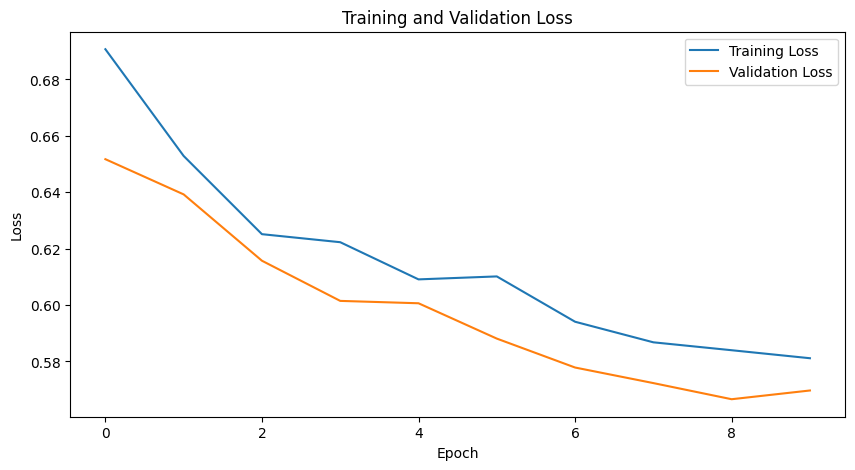

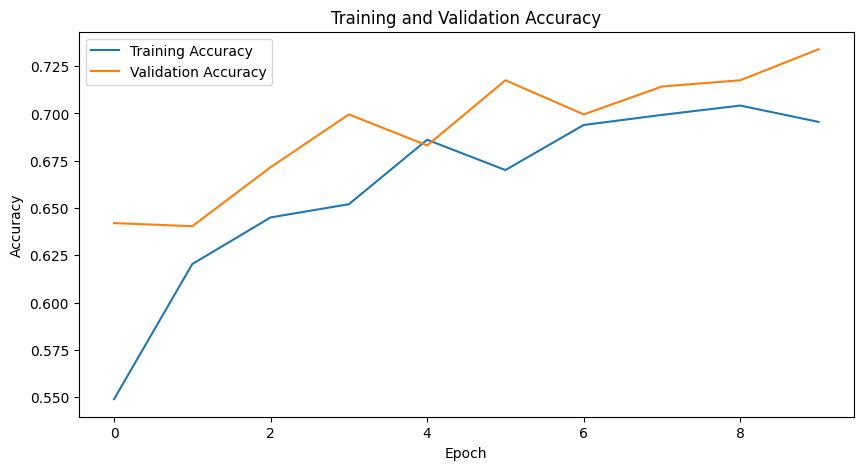

32/32 [==============================] - 70s 2s/step - loss: 0.5311 - accuracy: 0.7655 - precision: 0.7956 - recall: 0.7140
Test Loss: 0.53114253282547, Test Accuracy: 0.7655172348022461


In [48]:
# Train model. Graph validation loss and accuracy by epoch.
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_split=.2)
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate model
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Make some predictions on new data (optional)
# TODO: Write some code for this (later on)

Now, we will predict on unseen test data.

In [49]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
# our y-pred values are sigmoid values between 0 and 1. So, we need to convert them.
y_pred = [1 if score > 0.5 else 0 for score in y_pred]
y_test_ = list(y_test)

32/32 [==============================] - 45s 1s/step


For visualization purposes, we calculate confusion matrix to assess our model. 

Accuracy:  0.7655172413793103


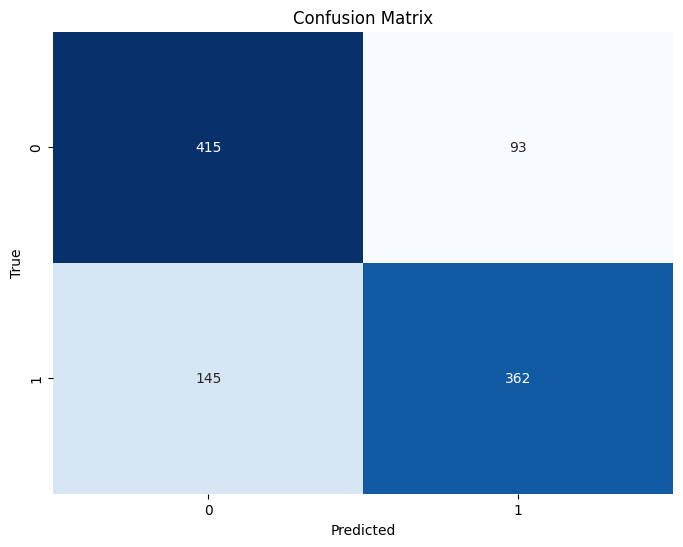

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       508
           1       0.80      0.71      0.75       507

    accuracy                           0.77      1015
   macro avg       0.77      0.77      0.76      1015
weighted avg       0.77      0.77      0.76      1015



In [50]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

# Calculate confusion matrix and accuracy
cm = confusion_matrix(y_test_, y_pred)
acc = accuracy_score(y_test_, y_pred)
print("Accuracy: ", acc)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test_, y_pred))
